## Multi-layer Perceptrons

In [17]:
%matplotlib inline

import pdb
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg

import warnings
warnings.filterwarnings('ignore')

## Neural net cost function with regularization

In [2]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size,
                     num_labels, X, y, lam):
    # nn_cost_function Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   J = nn_cost_function(nn_params, hidden_layer_size, num_labels,
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.

    # Reshape nn_params back into the parameters theta1 and theta2
    # for our 2 hidden-layer neural network
    mid = hidden_layer_size * input_layer_size
    theta1 = np.reshape(nn_params[:mid], (hidden_layer_size, input_layer_size)) #25x401
    theta2 = np.reshape(nn_params[mid:], (num_labels, hidden_layer_size + 1)) #10x26
    
    J = 0
    num_samples = X.shape[0]

    # add bias to the input data
    bias = np.ones((num_samples, 1))
    X1 = np.concatenate((bias, X), axis=1)

    # forward propagate
    layer1 = sigmoid(theta1.dot(X1.T))
    bias = np.ones((1, layer1.shape[1]))
    layer2 = np.concatenate((bias, layer1), axis=0)
    output = sigmoid(theta2.dot(layer2))

    # reshape y to nn format, one hot encoding
    ynn = np.zeros((num_samples, num_labels))
    for i in range(num_samples):
        ynn[i, y[i] -1] = 1 # column 10 represents digit 0
    #end
    ynn = ynn.T
    
    # cost function - first without regularization
    J = (-1 / num_samples) * np.sum(np.sum( ynn * np.log(output) + (1 - ynn) * np.log(1 - output) ))
    
    # cost function - first with regularization
    sum_layer1 = np.sum(np.sum( theta1[:, 1:-1] **2 ))
    sum_layer2 = np.sum(np.sum( theta2[:, 1:-1] **2 ))
    reg = (lam / (2 * num_samples)) * (sum_layer1 + sum_layer2)
    J = J + reg

    return J
#end


## Neural net cost function gradient

In [3]:
def nn_cost_function_gradient(nn_params, input_layer_size, hidden_layer_size, 
                              num_labels, X, y, lam):
    # nn_cost_function Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   grad = nn_cost_function(nn_params, hidden_layer_size, num_labels,
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.

    # Reshape nn_params back into the parameters theta1 and theta2
    # for our 2 hidden-layer neural network

    mid = hidden_layer_size * input_layer_size
    theta1 = np.reshape(nn_params[:mid], (hidden_layer_size, input_layer_size)) #25x401
    theta2 = np.reshape(nn_params[mid:], (num_labels, hidden_layer_size + 1)) #10x26
    
    num_samples = X.shape[0]
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    # add bias to the input data
    bias = np.ones((num_samples, 1))
    X1 = np.concatenate((bias, X), axis=1)
    
    # reshape y to nn format, one hot encoding
    ynn = np.zeros((num_samples, num_labels))
    for i in range(num_samples):
        ynn[i, y[i] -1] = 1 # column 10 represents digit 0
    #end
    ynn = ynn.T
    
    # backpropogation, calculation of gradients
    for t in range(num_samples):
        # step 1: forward propagate
        a1 = X1[t, :]
        z2 = theta1.dot(a1.T)
        a2 = sigmoid(z2)
        z2 = np.insert(z2, 0, 1) # need to account for the bias
        a2 = np.insert(a2, 0, 1) # need to account for the bias
        z3 = theta2.dot(a2.T)
        a3 = sigmoid(z3)

        # step 2: compute error
        delta3 = a3 - ynn[:, t]
        
        # step 3: back propagate error through activation function
        delta2 = (theta2.T.dot(delta3)) * sigmoid_gradient(z2)
        
        # step 4: update weights
        theta2_grad += np.outer(delta3, a2.T)
        theta1_grad += np.outer(delta2[1:], a1)
    # end
    
    # regularization
    theta1_tmp = np.copy(theta1)
    theta1_tmp[:, 0] = 0 # don't regularize bias terms
    theta1_grad = (theta1_grad + lam * theta1_tmp) / num_samples
    theta2_tmp = np.copy(theta2)
    theta2_tmp[:, 0] = 0
    theta2_grad = (theta2_grad + lam * theta2_tmp) / num_samples

    # unroll gradients
    theta1_flat = theta1_grad.flatten()
    theta2_flat = theta2_grad.flatten()
    grad = np.concatenate((theta1_flat, theta2_flat))
    
    return grad
# end


## Sigmoid function

In [4]:
def sigmoid(z):
    # sigmoid Compute sigmoid functoon
    # g = sigmoid(z) computes the sigmoid of z
    g = 1. / (1. + np.exp(-z))
    
    return g
# end


## Sigmoid gradient function

In [5]:
def sigmoid_gradient(z):
    # compute the gradient of the sigmoid function evaluated at
    # each value of z (z can be a matrix, vector or scalar)
    return sigmoid(z) * (1. - sigmoid(z))

## Classifying MNIST digits from pre-learned weights

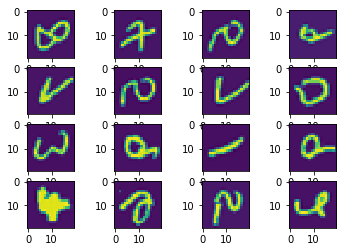

Loading saved neural network parameters ...

Training neural network... 

Cost without regularization: 0.2876 

Cost with regularization: 0.3811 

Training set accuracy: 97.52



In [25]:
def MNIST_pre_learn():
    # 5000 Mnist digits
    data = loadmat('ex4data1.mat')
    X = data['X']
    y = data['y']

    # 5000 samples, 500 from each class
    n = X.shape[0]

    # num of pixels per sample
    d = X.shape[1]

    # digits from 0 through 9
    c = np.unique(y).size

    # randomly select 16 image to display
    fig = plt.figure()
    for i in range(1, 17):
        index = np.random.randint(low=0, high=4999, size=1)
        image = np.reshape(X[index, :], (20, 20))
        fig.add_subplot(4, 4, i)
        plt.imshow(image)
    # end
    plt.show()

    # load pre-learned weights
    print('Loading saved neural network parameters ...\n')
    weights = loadmat('ex4weights.mat')
    theta1 = weights['Theta1']
    theta2 = weights['Theta2']
    weights_flat = np.concatenate((theta1.flatten(), theta2.flatten()))

    # cost without regularization
    print('Training neural network... \n')
    lam = 0
    J = nn_cost_function(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
    print('Cost without regularization: %2.4f \n' % J)

    # cost with regularization
    lam = 1
    J = nn_cost_function(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
    print('Cost with regularization: %2.4f \n' % J)

    # calculate accuracy
    bias = np.ones((n, 1))
    X1 = np.concatenate((bias, X), axis=1)

    layer1 = sigmoid(theta1.dot(X1.T))
    bias = np.ones((1, layer1.shape[1]))
    layer2 = np.concatenate((bias, layer1), axis=0)
    output = sigmoid(theta2.dot(layer2))

    predict = np.argmax(output, axis=0) + 1
    predict = predict.reshape(5000, 1)
    acc = np.sum(predict == y) / n * 100
    print('Training set accuracy: %2.2f\n' % acc)
# end

MNIST_pre_learn()

## Classifying MNIST digits from random weights

In [19]:
def MNIST_random_weights():
    # random number generator seed
    np.random.seed(2000)

    data = loadmat('ex4data1.mat')
    X = data['X']
    y = data['y']
    
    def print_progress(theta):
        # callback function for fmin_cg to print out process
        global Nfeval
        print('{0:4d}   {1: 2.4f}'.format(Nfeval, nn_cost_function(theta, d+1, t, c, X, y, lam)))
        Nfeval += 1
    # end

    # initializing random weights
    print('initializing neural network parameters ...\n')
    t = theta1.shape[0]
    layer1_size = t * (d + 1) # 25x401
    layer2_size = c * (t + 1) # 10x26
    init_theta = np.random.rand(layer1_size + layer2_size)

    # group the arguments
    args = (d+1, t, c, X, y, lam)

    # start minimizing cost
    print('Training neural network... \n')
    print('{0:4s}   {1:9s}'.format(' Epoch', ' Cost'))
    theta_opt = fmin_cg(nn_cost_function, init_theta, nn_cost_function_gradient,
                        args=args, maxiter=50, callback=print_progress, disp=0)
    
    # reshape the weights to correct sizes
    theta1_opt = np.reshape(theta_opt[:layer1_size], (t, d + 1)) # 25x401
    theta2_opt = np.reshape(theta_opt[layer1_size:], (c, t + 1)) # 10x26

    # forward propagate
    bias = np.ones((n, 1))
    X1 = np.concatenate((bias, X), axis=1)

    layer1 = sigmoid(theta1_opt.dot(X1.T))
    bias = np.ones((1, layer1.shape[1]))
    layer2 = np.concatenate((bias, layer1), axis=0)
    output = sigmoid(theta2_opt.dot(layer2))

    # find out accuracy
    predict = np.argmax(output, axis=0) + 1
    predict = predict.reshape(5000, 1)
    acc = np.sum(predict == y) / n * 100
    print('Training set accuracy: %2.2f\n' % acc)
# end

Nfeval = 1
MNIST_random_weights()

initializing neural network parameters ...

Training neural network... 

 Iter    Cost    
   1    6.3460
   2    3.6118
   3    3.5929
   4    3.5835
   5    3.5834
   6    3.4021
   7    3.2682
   8    3.2646
   9    3.2596
  10    3.2590
  11    3.2525
  12    3.1002
  13    3.0994
  14    3.0271
  15    2.9441
  16    2.8845
  17    2.8055
  18    2.7331
  19    2.6557
  20    2.6040
  21    2.5733
  22    2.4643
  23    2.3191
  24    2.2247
  25    2.1803
  26    2.0981
  27    2.0040
  28    1.9018
  29    1.7455
  30    1.5797
  31    1.5370
  32    1.4731
  33    1.4097
  34    1.3640
  35    1.3124
  36    1.1952
  37    1.1534
  38    1.1176
  39    1.0711
  40    1.0554
  41    1.0273
  42    0.9991
  43    0.9443
  44    0.9041
  45    0.8324
  46    0.7893
  47    0.7553
  48    0.7280
  49    0.7134
  50    0.6953
Training set accuracy: 91.50



## Classifying MNIST digits with Tensorflow

In [54]:
def MNIST_tensorflow():
    # 5000 Mnist digits 
    data = loadmat('ex4data1.mat')
    x_input = data['X']
    y_truth = data['y']

    # learning parameters
    tf.set_random_seed(2000)
    learning_rate = 0.001

    # Network Parameters
    epoch = 50
    batch_size = 100
    n_sample = 5000
    n_hidden = 25 
    n_input = 400 # MNIST data input image: 20x20 pixels
    n_class = 10 # 0 - 9 digits

    # convert group truth digits to one-hot encoding
    ynn = np.zeros((n_sample, n_class))
    for i in range(n_sample):
        ynn[i, y_truth[i] - 1] = 1 # column 1 represents digit 0
    #end

    # TF inputs
    X = tf.placeholder("float", [None, n_input])
    Y = tf.placeholder("float", [None, n_class])

    # hidden layer weights
    h1 = tf.Variable(tf.random_normal([n_input, n_hidden]))
    # hidden layer bias
    bias1 = tf.Variable(tf.random_normal([n_hidden]))
    # hidden layer output
    hidden = tf.nn.sigmoid(tf.add(tf.matmul(X, h1), bias1))

    # output layer weights
    h2 = tf.Variable(tf.random_normal([n_hidden, n_class]))
    # output layer bias
    bias2 = tf.Variable(tf.random_normal([n_class]))
    # output layer output
    output = tf.add(tf.matmul(hidden, h2), bias2)

    # cost function
    #cost = (-1 / n_sample) * tf.reduce_sum(tf.reduce_sum( Y * tf.log(output) + (1 - Y) * tf.log(1 - output) ))
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y))

    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # running tf graph
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for e in range(epoch):
            total_cost = 0
            for i in range(n_sample):
                # feed one image per iteration
                image = np.reshape(x_input[i, :], (1, n_input))
                label = np.reshape(ynn[i, :], (1, n_class))
                _, c = sess.run([optimizer, cost], feed_dict={X: image, Y: label})
                total_cost += c
            #end
            print("Epoch:", '%02d' % (e + 1), "cost: {:.9f}".format(total_cost / n_sample))
        print("Optimization Finished!")
        # end
        
        # test model
        pred = tf.nn.sigmoid(output) + 1
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
        print("Model Accuracy:", accuracy.eval({X: x_input, Y: ynn}))
    # end
# end

MNIST_tensorflow()

Epoch: 01 cost: 0.798212781
Epoch: 02 cost: 0.387366473
Epoch: 03 cost: 0.254564888
Epoch: 04 cost: 0.190380959
Epoch: 05 cost: 0.157003216
Epoch: 06 cost: 0.132528698
Epoch: 07 cost: 0.115226429
Epoch: 08 cost: 0.099945371
Epoch: 09 cost: 0.088389807
Epoch: 10 cost: 0.080059661
Epoch: 11 cost: 0.073649087
Epoch: 12 cost: 0.067649424
Epoch: 13 cost: 0.061891517
Epoch: 14 cost: 0.056519179
Epoch: 15 cost: 0.051531172
Epoch: 16 cost: 0.047003600
Epoch: 17 cost: 0.043041695
Epoch: 18 cost: 0.039651683
Epoch: 19 cost: 0.036697847
Epoch: 20 cost: 0.034262845
Epoch: 21 cost: 0.032371727
Epoch: 22 cost: 0.030721056
Epoch: 23 cost: 0.029018543
Epoch: 24 cost: 0.027315660
Epoch: 25 cost: 0.025635299
Epoch: 26 cost: 0.023654585
Epoch: 27 cost: 0.021629063
Epoch: 28 cost: 0.019861322
Epoch: 29 cost: 0.018462364
Epoch: 30 cost: 0.017346129
Epoch: 31 cost: 0.016432265
Epoch: 32 cost: 0.015785623
Epoch: 33 cost: 0.015309706
Epoch: 34 cost: 0.014971807
Epoch: 35 cost: 0.014669625
Epoch: 36 cost: 0.01

ValueError: Cannot feed value of shape (5000, 400) for Tensor 'Placeholder_46:0', which has shape '(1, 400)'